<a href="https://colab.research.google.com/github/hosseinimohmah-AI/Deep-Learning/blob/main/23-image-localization-regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
!pip install --quiet gdown


!gdown --id 1yDktXuw16oRq0v_TwihBTP9KX6mJ4VhX


!unzip -q /content/Diverse_hand_gesture_dataset.zip

KeyboardInterrupt: 

This notebook is part of "Object detection course":
    https://github.com/Alireza-Akhavan/object-detection-notebooks

In [1]:
import tensorflow as tf
print(tf.__version__)
tf.config.list_physical_devices()

2.20.0


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

In [2]:
from tensorflow.keras.applications.vgg16 import VGG16
from keras.applications.resnet import ResNet50
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os

In [ ]:
folder_path = "content/train"


In [ ]:
# for Numbb , filename in enumerate(os.listdir(BASE_PATH)):
#     if filename.endswith(".txt"):
#         file_path = os.path.join(BASE_PATH, filename)

#         with open(file_path, "r", encoding="utf-8") as f:
#           content = f.read()
#           Rows = content.strip().split(" ")
#           print("TXT Content from", filename)
#           print(content)

#     elif filename.endswith(".png"):
#         img = Image.open(file_path)
#         print("IMAGE:", filename, img.size)


# rows = open(ANNOTS_PATH).read().strip().split("\n")

In [6]:

png_files = []
txt_files = []

for filename in os.listdir(folder_path):
    file_path = os.path.join(folder_path, filename)

    if filename.lower().endswith(".png"):
        png_files.append(file_path)

    elif filename.lower().endswith(".txt"):
        txt_files.append(file_path)

In [7]:
png_files.sort()
txt_files.sort()


In [8]:
print(png_files[123])
print(txt_files[123])

content/train\1122.png
content/train\1122.txt


In [9]:
danesh = []
i = 0
for fold in txt_files:
    with open(fold, "r", encoding="utf-8") as f:
        content = f.read().strip().split(" ")
        danesh.append(content)
        i += 1
        if i == 10:
          break

print(danesh)

[['0', '0.511161', '0.562500', '0.245536', '0.312500'], ['0', '0.386161', '0.537946', '0.281250', '0.290179'], ['4', '0.848214', '0.305804', '0.303571', '0.593750'], ['4', '0.564732', '0.334821', '0.236607', '0.419643'], ['4', '0.566964', '0.258929', '0.223214', '0.401786'], ['4', '0.575893', '0.475446', '0.232143', '0.450893'], ['4', '0.544643', '0.756696', '0.223214', '0.397321'], ['4', '0.738839', '0.761161', '0.191964', '0.397321'], ['4', '0.662946', '0.745536', '0.209821', '0.419643'], ['4', '0.535714', '0.620536', '0.250000', '0.401786']]


In [10]:
rows = []
for fold in txt_files:
    with open(fold, "r", encoding="utf-8") as f:
        content = f.read().strip().split(" ")
        rows.append(content)



In [11]:
def list_shape(lst):
    if isinstance(lst, list):
        return [len(lst)] + list_shape(lst[0])
    else:
        return []

shape = list_shape(rows)
print(shape)

[6400, 5]


In [ ]:

data = []
targets = []
filenames = []

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


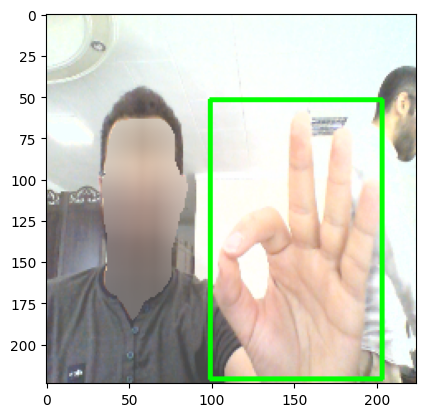

In [28]:
recsss = cv2.rectangle(data[55], (int(targets[55][0]), int(targets[55][1])), (int(targets[55][2]), int(targets[55][3])), (0, 255, 0), 2)
plt.imshow(recsss)
# plt.show()

In [13]:
from numpy._core.defchararray import center
# loop over the rows
for i , row in enumerate(rows):
    # break the row into the filename and bounding box coordinates
    (class_id ,center_x ,center_y ,width, height) = row

    # derive the path to the input image, load the image (in OpenCV
    # format), and grab its dimensions
    imagePath = png_files[i]
    image = cv2.imread(imagePath)
    (w, h) = image.shape[:2]

    # scale the bounding box coordinates relative to the spatial
    # dimensions of the input image
    centerX = float(center_x) * w
    centerY = float(center_y) * h
    realW   = float(width)  * w
    realH   = float(height) * h


    # load the image and preprocess it
    image = load_img(imagePath, target_size=(224, 224))
    image = img_to_array(image)

    # update our list of data, targets, and filenames
    data.append(image)
    startX = centerX - realW / 2
    startY = centerY - realH / 2
    endX   = centerX + realW / 2
    endY   = centerY + realH / 2
    targets.append((startX, startY, endX, endY))
    filenames.append(filename)

In [14]:
print(targets[0])

(87.00003199999999, 91.0, 142.00009599999998, 161.0)


In [15]:
# convert the data and targets to NumPy arrays, scaling the input
# pixel intensities from the range [0, 255] to [0, 1]
data = np.array(data, dtype="float32") / 255.0
targets = np.array(targets, dtype="float32")

In [16]:
# partition the data into training and testing splits using 90% of
# the data for training and the remaining 10% for testing
split = train_test_split(data, targets, filenames, test_size=0.15, random_state=42)

# unpack the data split
(trainImages, testImages) = split[:2]
(trainTargets, testTargets) = split[2:4]
(trainFilenames, testFilenames) = split[4:]

In [31]:
# load the VGG16 network, ensuring the head FC layers are left off
vgg = VGG16(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 103s 2us/step


In [33]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import pickle
import cv2
import os
%matplotlib inline

In [35]:
# flatten the max-pooling output of VGG
flatten = vgg.output
flatten = Flatten()(flatten)

# construct a fully-connected layer header to output the predicted
# bounding box coordinates
bboxHead = Dense(128, activation="relu")(flatten)
bboxHead = Dense(64, activation="relu")(bboxHead)
bboxHead = Dense(32, activation="relu")(bboxHead)
bboxHead = Dense(4, activation="sigmoid", name="bounding_box")(bboxHead)

# construct a second fully-connected layer head, this one to predict
# the class label
softmaxHead = Dense(512, activation="relu")(flatten)
softmaxHead = Dropout(0.5)(softmaxHead)
softmaxHead = Dense(512, activation="relu")(softmaxHead)
softmaxHead = Dropout(0.5)(softmaxHead)
softmaxHead = Dense(10, activation="softmax", name="class_label")(softmaxHead)

# put together our model which accept an input image and then output
# bounding box coordinates and a class label
model = Model(inputs=vgg.input, outputs=(bboxHead, softmaxHead))

In [18]:
model = Sequential()
model.add(Resnets)
model.add(Flatten())
model.add( Dense(128, activation="relu"))
model.add( Dense(64, activation="relu"))
model.add( Dense(32, activation="relu"))
model.add( Dense(4, activation="sigmoid"))

In [36]:
vgg.trainable = False

In [37]:
model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 224, 224,  │      1,792 │ input_layer_3[0]… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 224, 224,  │     36,928 │ block1_conv1[0][… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_pool         │ (None, 112, 112,  │          0 │ block1_conv2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv1        │ (None, 112, 112,  │     73,856 │ block1_pool[0][0] │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv2        │ (None, 112, 112,  │    147,584 │ block2_conv1[0][… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 56, 56,    │          0 │ block2_conv2[0][… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv1        │ (None, 56, 56,    │    295,168 │ block2_pool[0][0] │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv2        │ (None, 56, 56,    │    590,080 │ block3_conv1[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv3        │ (None, 56, 56,    │    590,080 │ block3_conv2[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_pool         │ (None, 28, 28,    │          0 │ block3_conv3[0][… │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv1        │ (None, 28, 28,    │  1,180,160 │ block3_pool[0][0] │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv2        │ (None, 28, 28,    │  2,359,808 │ block4_conv1[0][… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv3        │ (None, 28, 28,    │  2,359,808 │ block4_conv2[0][… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_pool         │ (None, 14, 14,    │          0 │ block4_conv3[0][… │
│ (MaxPooling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block5_conv1        │ (None, 14, 14,    │  2,359,808 │ block4_pool[0][0] │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block5_conv2        │ (None, 14, 14,    │  2,359,808 │ block5_conv1[0][

 Total params: 31,049,902 (118.45 MB)

 Trainable params: 16,335,214 (62.31 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [23]:
opt = Adam(learning_rate=1e-4)
model.compile(loss="mse", optimizer=opt,metrics=['accuracy'])

In [25]:
H = model.fit(
trainImages, trainTargets,
validation_data=(testImages, testTargets),
batch_size=128,
epochs=15,
verbose=1)

Epoch 1/15
43/43 ━━━━━━━━━━━━━━━━━━━━ 339s 8s/step - accuracy: 0.3423 - loss: 17312.6074 - val_accuracy: 0.3521 - val_loss: 17355.3730
Epoch 2/15
 1/43 ━━━━━━━━━━━━━━━━━━━━ 4:41 7s/step - accuracy: 0.3438 - loss: 17435.3730

KeyboardInterrupt: 

In [ ]:
model.save("localization.keras")

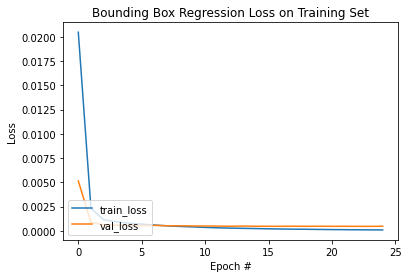

In [ ]:
N = H.params['epochs']
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.title("Bounding Box Regression Loss on Training Set")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")

Source:

https://www.pyimagesearch.com/2020/10/05/object-detection-bounding-box-regression-with-keras-tensorflow-and-deep-learning/